
## LSTM model to predict Effective Porosity

#### Shadya Taleb, st36223
#### Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

* There are millions of well logs from the oil ang gas industry that can be used to characterize geological carbon storage (GCS) projects, these well logs have most of their information in certain intervals and some other information missing in the GSC intervals of interest. The question is how can we use machine learning to approach this missing information (i.e., effective porosity) from the information that's available?

* This project uses a machine learning model called Long Short-Term Memory (LSTM), we compare different combinations of hyperparameters to reduce the error and obtain an improved result.

* Results show how  by iterating betweeen certain hyperparameters the error can be reduced from 0.02 ti 0.004. It was observed that the batch size is not influencing our model error by a lot, but a very low learning rate (0.0001) does have an influence on the error by almost an order of magnitude

* Recommendations include, trying to add hidden layers in the model and see if this has a bigger influence and see if it can be improved.


### Import Packages

In [77]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(78728)


import keras
from keras import Model, Input
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error

### Machine Learning using Long Short-Term Memory (LSTM) 

* LSTM is a type of artificial neural network (ANN), it is used for continous data (Time Series) beacuse it is capable of learning order dependence. It can be useful as well for well log information, because although the information is not given by changing time, it changes by depth, and our LSTM model could make predictions based on depth dependance.

* An important assumption when using LSTM model is that the model assumes that the information current step depends on the information from the previous step and it is also important to highlight some limitations such as requiring more memory to run and its sensitivity to overfitting.

### 1. Load Data

The following workflow applies the well log 1044249719 a file that is publicly available from the Kansas Geological Survey (https://www.kgs.ku.edu/Magellan/Logs/index.html). The .las file was previously converted to .csv and the calculated effective porosity was added in a new column called PHIE. 

We will work with the following features imported from the .csv file:

* **depth (DEPT)** - well log depth
* **efective porosity (PHIE)** - connected fraction of rock void, units (fraction)
* **spontaneous potential well log values (SP)** - potential between the borehole fluid and the surrounding rock and fluids, units (mV)
* **density well log values (RHOB)** - measures the density the rocks at current depth, units (g/cm3)
* **density porosity well log values (DPHI)** - reflects "free" water in the sandstones, and bound water in the shales, units (fraction)

In [78]:
# load .csv file from github

df = pd.read_csv("https://raw.githubusercontent.com/shadyataleb/Well_log_prediction/main/1044249719.csv")
data = df.drop(df.columns[[0]], axis=1) 
data.tail()

,DEPT,GR,SP,RHOB,DPHI,NPHI,VSHALE,PHIT,PHIE
7597,4043.5,195.2213,-111.5597,2.5162,0.113306,0.106957,0.340620,0.110177,0.072649
7598,4044.0,231.3064,-109.5491,2.5348,0.102456,0.094573,0.352903,0.098593,0.063799
7599,4044.5,273.7679,-107.8978,2.5494,0.093932,0.081600,0.362991,0.087982,0.056046
7600,4045.0,299.3691,-106.6720,2.5579,0.088935,0.069824,0.370479,0.079953,0.050332
7601,4045.5,308.3871,-105.8901,2.5613,0.086930,0.060152,0.375256,0.074750,0.046700


### 2. Visualize Data

Observe the effective porosity distribution and its correlation with all the other values in our dataset

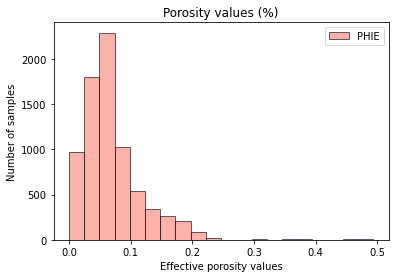

In [79]:
# effective porosity distribution 

plt.hist(data.PHIE, alpha=0.6, label = 'PHIE', color = 'salmon', edgecolor = 'black', bins=20)
plt.title("Porosity values (%)")
plt.ylabel('Number of samples')
plt.xlabel("Effective porosity values")
plt.legend();

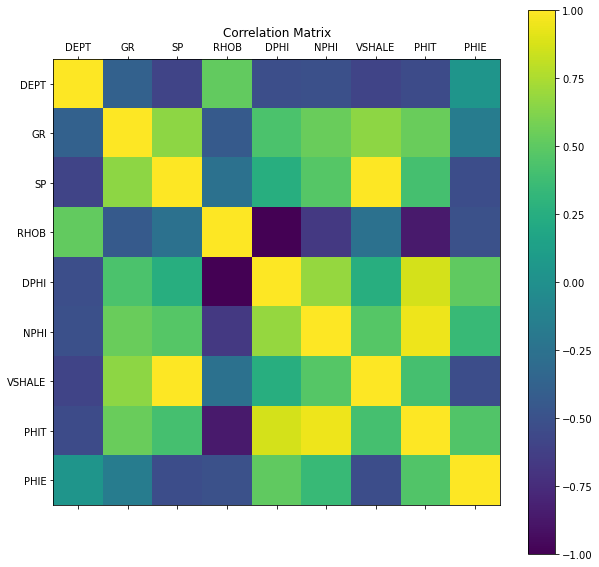

In [80]:
#  correlation matrix using function defined 

def plot_corr(data,size=10):
    ## plot correlation matrix
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
## function from Professor Michael Pyrcz:
## https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_DecisionTree.ipynb

corr_matrix = np.corrcoef(data, rowvar = False)
plot_corr(data,10)                                       # using our correlation matrix visualization function
plt.show()

### 3. Build LSTM Model

Select SP, Density (RHOB) and Density porosity (DPHI) well logs as predictors of Effective Porosity (PHIE)

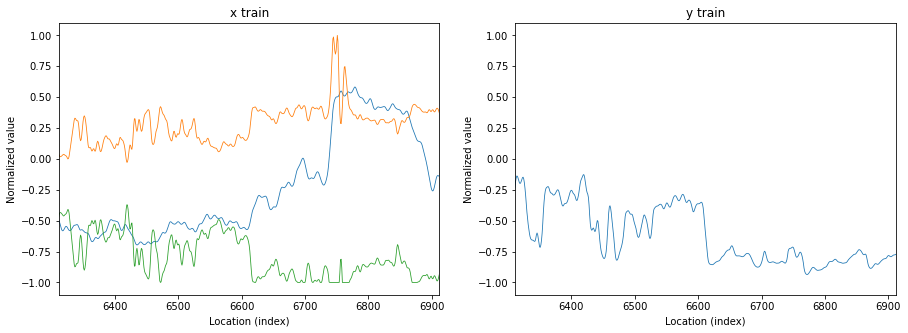

In [92]:
X_data = data[['SP', 'RHOB', 'DPHI']]
y_data = data['PHIE']

# normalize data between -1 and 1

x_train = 2*(X_data-X_data.min())/(X_data.max()-X_data.min())-1
y_train = 2*(y_data-y_data.min())/(y_data.max()-y_data.min())-1

# visualize normalized data between 3400' and 3700'

fig =plt.figure(figsize=(15,5))

# x_train
a1 = fig.add_subplot(121)
a1.set_xlim([6312, 6912])
a1.plot(x_train,  lw=0.8)
a1.set_xlabel('Location (index)')
a1.set_ylabel('Normalized value')
a1.set_title('x train')

# y_train
a2 = fig.add_subplot(122)
a2.set_xlim([6312, 6912])
a2.plot(y_train, lw=0.8)
a2.set_xlabel('Location (index)')
a2.set_ylabel('Normalized value')
a2.set_title('y train');

Create our LSTM model

In [93]:
# Verify shape of my predictor values (x_train) and re-shape it using total number of samples
depths = X_data.shape[0]
x_train = np.expand_dims(np.reshape(x_train, (depths,3)), -1)


# Define function to create LSTM model
def make_model():     
    keras.backend.clear_session()
    inp = Input(shape=(3,1))

    x = LSTM(10)(inp)

    out = Dense(1)(x)
    return Model(inp, out)

# create LSTM model
my_lstm = make_model()
my_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


#### Choosing initial hyperparameters

We chose to work with Adam optimizer, because it combines advantages of stochastic gradient descent, Adagrad and RMSProp, which helps improve the results with a better computational time. Other values such as batch size and learning rate we chose initial values of 128 and 0.001 but later on we will iterate to find a better match. 

MSE= 0.020661079891345753


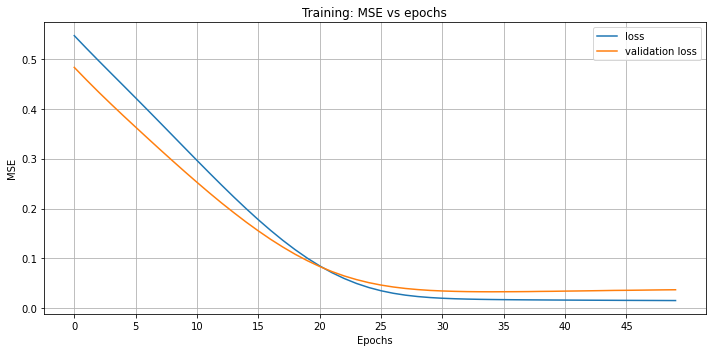

In [94]:
# Compile 
keras.backend.clear_session()
my_lstm.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001), 
                loss = 'mse',
                metrics = ['mse'])

# Train the network
fit = my_lstm.fit(x_train, y_train,
                    epochs = 50,
                    batch_size = 128,
                    validation_split = 0.25,
                    verbose = 0)

# Predict with the Network
y_pred = my_lstm.predict(x_train)
MSE = mean_squared_error(y_train, y_pred)

# saving info to plot the Model 

data["PHI_PRED"] = pd.DataFrame(y_pred)
phi_e_ =  data['PHIE']
phi_e = 2*(y_data-y_data.min())/(y_data.max()-y_data.min())-1
depth = data['DEPT'].values
phi_pred = data['PHI_PRED'].values

# define plot function
def plot_loss(fit):
    # plot loss 
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: MSE vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('MSE')
    plt.xticks(iterations[::epochs//10])
    plt.tight_layout()
    plt.grid()
    
# check loss plot using function defined
plot_loss(fit)
print('MSE=',MSE)

Visualize predicted vs true values 

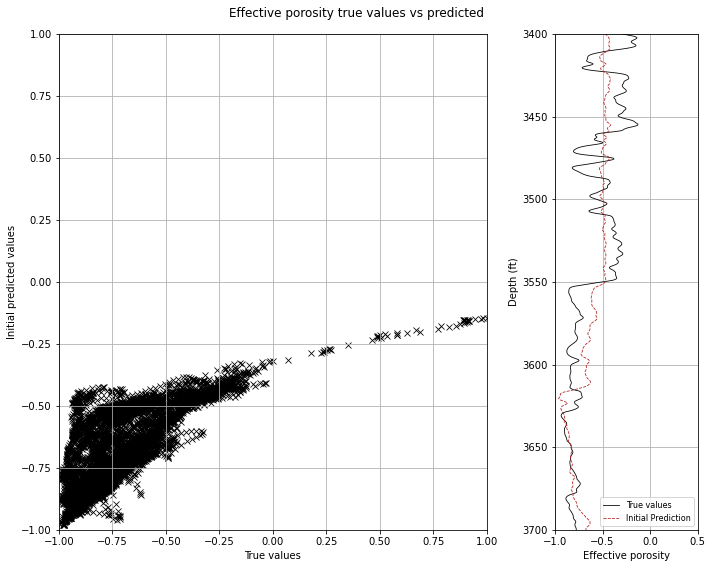

In [95]:
# plot initial predictions

fig = plt.figure(figsize=(10, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
a0 = plt.subplot(gs[0])
a1 = plt.subplot(gs[1])


a0.scatter(y_train, y_pred, marker="x", c="k", lw=0.8)
a0.set_xlim([-1, 1])
a0.set_ylim([-1, 1])
a0.set_xlabel('True values')
a0.set_ylabel('Initial predicted values')
a0.grid()

a1.plot(phi_e, depth, label="True values", color='k', lw=0.8)
a1.plot(phi_pred, depth, label="Initial Prediction", color='firebrick', ls="dashed", lw=0.8)
a1.set_xlim([-1, 0.5])
a1.set_ylim([3700, 3400])
a1.legend(loc='lower right',fontsize = '8')
a1.set_xlabel('Effective porosity')
a1.set_ylabel('Depth (ft)')
a1.grid()

fig.suptitle('Effective porosity true values vs predicted')
plt.tight_layout()

### 4. Hyperparameter tuning

Now that we have an initial guess using the defined LSTM model, let's test how the following hyperparameters affect the MSE in the model, in order to find the best combination:

* Number of units in the LSTM layer
* Activation function
* Learning rate

In order to do so, let's replace the initial value for a variable called "units" and define the function, then iterate between different unit values to create different models:

In [58]:
# create function to create model with different unit numbers
def make_model1(units):
    keras.backend.clear_session()
    inp = Input(shape=(3,1))

    x = LSTM(units)(inp)
    
    out = Dense(1)(x)
    return Model(inp, out)

# Units in LSTM model
units = [10, 20, 30, 40, 50]

# Create models
for u in units:
    my_lstm = make_model1(u)
    my_lstm.summary()
    print(u)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
10
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                1760      
_____________________________________________

Let's create another function to train the model using our previous models with different units and change learning rate and batch size

Iterate between the values of:
* Number of units in the LSTM layer (from 10 to 50)
* Learning rate (from 0.0001 to 0.01)
* Batch size (from 32 to 128)

In [63]:
# define compile, train and fit function for the parameters I want to change:

def train_model(my_lstm, lr, batch_size):
    keras.backend.clear_session()
    my_lstm.compile(optimizer = tf.optimizers.Adam(learning_rate=lr), 
                loss = 'mse',
                metrics = ['mse'])
    
    fit = my_lstm.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = batch_size,
                    validation_split = 0.25,
                    verbose = 0)
    
    y_pred = my_lstm.predict(x_train)
    return y_train, y_pred


# Create a dataframe to store the information that we well obtain
df2 = pd.DataFrame(columns = ['mse', 'units', 'lr', 'batch_size'])

# Units in LSTM model
units = [10, 20, 30, 40, 50]
lr = [0.0001, 0.001, 0.01]
batch_size= [32, 64, 128]
mse_ea = []

for u in units:
    my_lstm = make_model1(u)
    for l in lr:
        for bs in batch_size:
            y_train, y_pred = train_model(my_lstm, l, bs)
            MSE = mean_squared_error(y_train, y_pred)
            df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)
    #my_lstm.summary()
            print(u, l, bs, MSE)

<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.0001 32 0.020196716633926887


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.0001 64 0.014620358857008638


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.0001 128 0.012611116998798867


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.001 32 0.005013632652420527


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.001 64 0.005076760476534941


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.001 128 0.00474585630128489


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.01 32 0.005396167943373194


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.01 64 0.004666772552604174


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


10 0.01 128 0.0047890123103763475


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.0001 32 0.016666479818549882


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.0001 64 0.011153634451669947


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.0001 128 0.00908289944194878


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.001 32 0.005013902015768483


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.001 64 0.004795284274661163


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.001 128 0.0046958892088201365


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.01 32 0.0046805255950108735


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.01 64 0.004959806214102584


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


20 0.01 128 0.0048855394293780404


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.0001 32 0.01810015828236283


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.0001 64 0.011165734040845669


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.0001 128 0.008617064211481569


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.001 32 0.005003115529811729


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.001 64 0.004670960244041809


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.001 128 0.004771314137158989


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.01 32 0.004473396908999275


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.01 64 0.004934641816699798


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


30 0.01 128 0.005467078779986669


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.0001 32 0.01441933451376904


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.0001 64 0.007927121765535675


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.0001 128 0.005501052013670095


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.001 32 0.005080981954631218


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.001 64 0.004799801952130999


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.001 128 0.005116832597149836


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.01 32 0.004265235142752445


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.01 64 0.004865419137287196


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


40 0.01 128 0.0049643851840768


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.0001 32 0.013426195546616738


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.0001 64 0.00634683803830958


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.0001 128 0.005114056289274643


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.001 32 0.0051004776946110345


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.001 64 0.004897199963806938


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.001 128 0.0052675346355719735


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.01 32 0.004309500614194822


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


50 0.01 64 0.0049590285353648235
50 0.01 128 0.004924274203183018


<ipython-input-63-2264b2c12501>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'mse' : MSE, 'units' : u, 'lr' : l, 'batch_size': bs}, ignore_index = True)


### 5. Results

We evaluated how the following values affect our LSTM model:

* Number of units in the LSTM layer
* Activation function
* Learning rate

And calculated the Mean Square Error (MSE) for each case (combination). With this information, we found the best and worst combination of hyperparameters, based on the lowest and higher error:

In [98]:
# sort by unit values
df2 = df2.sort_values(by= ['lr'], ascending=True)
#df2 = df2.drop(['case'], axis=1)

# reset index 
df2.reset_index(drop=True,inplace=True)

# assign a number or each combination (case)
df2.insert(0, 'case', range(1, 1 + len(df2)))

# best case
print('Best case ---->', df2[df2['mse'] == df2['mse'].min()])

# worst case
print('Worst case ---->', df2[df2['mse'] == df2['mse'].max()])

Best case ---->     case       mse units    lr batch_size
37    38  0.004265  40.0  0.01       32.0
Worst case ---->    case       mse units      lr batch_size
0     1  0.020197  10.0  0.0001       32.0


The following plot shows the MSE for every case and the lower is highlighted in blue. It's recommended to use a # of units of 40, a learning rate of 0.01 and a batch size of 64 to obtain the smallest error, but after case 18 (when we increase the learning rate from 0.0001 to 0.001), the change in error is very small.

In [69]:
# Import required module
import altair as alt
import pandas as pd
  
alt.Chart(df2).mark_bar().encode(
    x='case',
    y="mse",
      
    # The highlight is set based on the result 
    # of the conditional statement
    color=alt.condition(
        alt.datum.mse >= 0.0043,  # If the rating is 80 it returns True,
        alt.value('salmon'),      # and the matching bars are set as green.
        # and if it does not satisfy the condition 
        # the color is set to steelblue.
        alt.value('blue')
    )
).properties(width=500)

alt.Chart(...)

Visualize initial predicted and final predicted vs true values. The final model tuned with improved hyperparameters is shown in the blue line in the following plot:

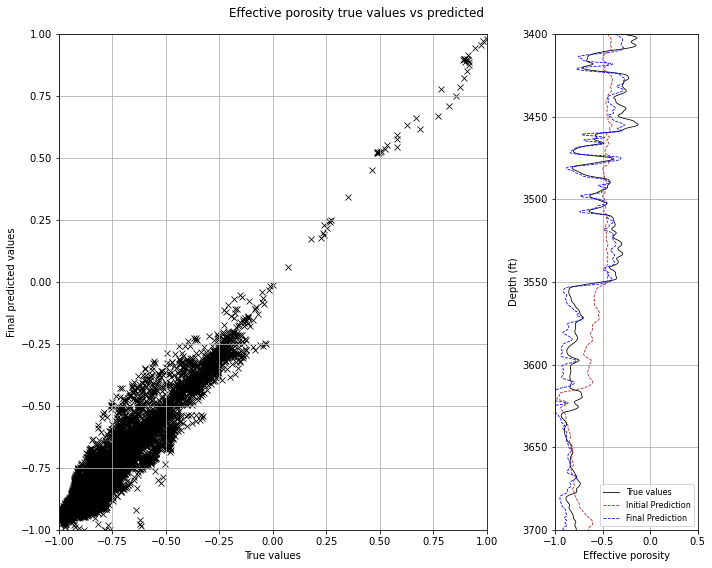

In [75]:
# create model
my_lstm2 = make_model1(40)

#compile, train and precit
y_train2, y_pred2 = train_model(my_lstm2, 0.01, 32)
MSE = mean_squared_error(y_train2, y_pred2)

# save info to plot the Model 
data["PHI_PRED2"] = pd.DataFrame(y_pred2)
phi_pred2 = data['PHI_PRED2'].values

# plot initial predictions
fig = plt.figure(figsize=(10, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
a0 = plt.subplot(gs[0])
a1 = plt.subplot(gs[1])


a0.scatter(y_train, y_pred2, marker="x", c="k", lw=0.8)
a0.set_xlim([-1, 1])
a0.set_ylim([-1, 1])
a0.set_xlabel('True values')
a0.set_ylabel('Final predicted values')
a0.grid()

a1.plot(phi_e, depth, label="True values", color='k', lw=0.8)
a1.plot(phi_pred, depth, label="Initial Prediction", color='firebrick', ls="dashed", lw=0.8)
a1.plot(phi_pred2, depth, label="Final Prediction", color='Blue', ls="dashed", lw=0.8)
a1.set_xlim([-1, 0.5])
a1.set_ylim([3700, 3400])
a1.legend(loc='lower right',fontsize = '8')
a1.set_xlabel('Effective porosity')
a1.set_ylabel('Depth (ft)')
a1.grid()

fig.suptitle('Effective porosity true values vs predicted')
plt.tight_layout()

### Final comments

* We found a combination of parameters that helped improve our model error from 0.02 to 0.004, by iterating the values    for learning rate, batch size and units in the LSTM model.

* There was a noticeably higher model error when decreasing the learning rate to 0.0001 and there was not a big difference when using 0.001 and 0.01.   

* Adding more information (more logs) as training data improves enormously the predicted results, unfortunately, not always this amount of data is available for prediciton, that's why I used limited amount of well log information.

__________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
